In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


**Importing Libraries**

In [30]:
import os
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
import altair as alt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [5]:
folder_path = '/kaggle/input/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
# test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
# test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
# sub = pd.read_csv(f'{folder_path}sample_submission.csv')

In [4]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
del train_identity, train_transaction
# test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Feature Engineering

In [6]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, null_threshold=0.9, value_dominance_threshold=0.9):
        self.null_threshold = null_threshold
        self.value_dominance_threshold = value_dominance_threshold
        self.cols_to_drop_ = None
    
    def fit(self, X, y=None):
        many_null_cols = self._get_null_columns(X)
        big_top_value_cols = self._get_dominant_value_columns(X)
        one_value_cols = self._get_single_value_columns(X)
        
        self.cols_to_drop_ = list(set(many_null_cols + big_top_value_cols + one_value_cols))
        
        self.cols_to_drop_ = [col for col in self.cols_to_drop_ if col != 'isFraud']
        
        return self
    
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, axis=1, errors='ignore')
    
    def _get_null_columns(self, df):
        return [col for col in df.columns 
                if df[col].isnull().sum() / len(df) > self.null_threshold]
    
    def _get_dominant_value_columns(self, df):
        dominant_cols = []
        for col in df.columns:
            value_counts = df[col].value_counts(dropna=False, normalize=True)
            if len(value_counts) > 0 and value_counts.iloc[0] > self.value_dominance_threshold:
                dominant_cols.append(col)
        return dominant_cols
    
    def _get_single_value_columns(self, df):
        return [col for col in df.columns if df[col].nunique(dropna=False) == 1]

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_fill_value="Unknown", num_strategy="median"):
        self.cat_fill_value = cat_fill_value
        self.num_strategy = num_strategy
        self.num_fill_values_ = {}
        self.categorical_columns_ = None
        self.numerical_columns_ = None
    
    def fit(self, X, y=None):
        self.categorical_columns_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.numerical_columns_ = X.select_dtypes(include=['number']).columns.tolist()
        
        if self.num_strategy == "median":
            for col in self.numerical_columns_:
                self.num_fill_values_[col] = X[col].median()
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.categorical_columns_:
            X_transformed[col] = X_transformed[col].fillna(self.cat_fill_value)
        
        for col in self.numerical_columns_:
            X_transformed[col] = X_transformed[col].fillna(self.num_fill_values_[col])
        
        return X_transformed

In [8]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold
    
    def fit(self, X, y):
        cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        s = X[cat_cols].nunique()
        self.woe_columns = s[s > self.threshold].index.tolist()
        self.one_hot_columns = s[s <= self.threshold].index.tolist()
        
        # Store most frequent category to handle missing values
        self.woe_columns_fill_na = X[self.woe_columns].mode().iloc[0].to_dict()
        
        woe_mappings = {}
        iv_values = {}
        df = X.copy()
        df['_target_'] = y
        
        for col in self.woe_columns:
            groups = df.groupby(col, dropna=False)['_target_'].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / max(groups['n_pos'].sum(), 1e-6)
            groups['prop_neg'] = groups['n_neg'] / max(groups['n_neg'].sum(), 1e-6)
            groups['woe'] = np.log((groups['prop_pos'] + 1e-6) / (groups['prop_neg'] + 1e-6))
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            groups = groups.replace([np.inf, -np.inf], 0).fillna(0)
            woe_mappings[col] = groups['woe'].to_dict()
            iv_values[col] = groups['iv'].sum()
            
        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.woe_columns:
            mapping = self.woe_mappings[col]
            default_value = mapping.get(self.woe_columns_fill_na[col], 0)
            
            # Transform column and handle unseen values
            transformed_col = X_transformed[col].map(lambda x: mapping.get(x, default_value))
            X_transformed[f'woe_{col}'] = transformed_col
            X_transformed.drop(columns=col, inplace=True)
        
        # One-hot encode remaining columns
        if self.one_hot_columns:
            X_transformed = pd.get_dummies(
                X_transformed,
                columns=self.one_hot_columns,
                drop_first=True,
                dummy_na=True,
                dtype=int
            )
        
        # Final check for NaNs
        if X_transformed.isnull().any().any():
            nan_cols = X_transformed.columns[X_transformed.isnull().any()].tolist()
            raise ValueError(f"Unexpected NaNs found in columns: {nan_cols}")
            
        return X_transformed

In [10]:
class NumericalProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold=3.5):
        self.z_threshold = z_threshold
        self.medians_ = {}
        self.mads_ = {}

    def fit(self, X, y=None):
        print('NumericalProcessor\n')
        num_cols = X.select_dtypes(include=np.number).columns
        self.medians_ = {col: X[col].median() for col in num_cols}
        self.mads_ = {col: np.median(np.abs(X[col] - self.medians_[col])) + 1e-10 for col in num_cols}
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.medians_:
            med = self.medians_[col]
            mad = self.mads_[col]
            modified_z = 0.6745 * (X[col] - med) / mad  # Modified Z-score
            X[f'{col}_outlier'] = (np.abs(modified_z) > self.z_threshold).astype(int)
        return X

In [11]:
class SelectColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return X[self.columns]

In [12]:
preprocessing = Pipeline([
    ('dropper', ColumnDropper()),
    ('imputer', MissingValueImputer()),
    ('cat_encoder', CategoricalEncoder()),
    ('num_processor', NumericalProcessor())
])

In [13]:
X = train.drop('isFraud', axis=1)
y = train['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensions of the train dataset is {X_train.shape} and {y_train.shape}')
print(f'Dimensions of the validation dataset is {X_valid.shape} and {y_valid.shape}')

del train

Dimensions of the train dataset is (472432, 433) and (472432,)
Dimensions of the validation dataset is (118108, 433) and (118108,)


In [14]:
import time

# Start timer
start_time = time.time()

X_t = preprocessing.fit_transform(X_train, y_train)
X_t

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(elapsed_time)

NumericalProcessor

39.50500679016113


In [15]:
X_v = preprocessing.transform(X_valid)
X_v

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,woe_ProductCD,woe_card4,woe_card6,woe_P_emaildomain,woe_R_emaildomain,woe_M4,woe_id_30,woe_id_31,woe_id_33,woe_id_34,woe_DeviceInfo,M1_T,M1_Unknown,M1_nan,M2_T,M2_Unknown,M2_nan,M3_T,M3_Unknown,M3_nan,M5_T,M5_Unknown,M5_nan,M6_T,M6_Unknown,M6_nan,M7_T,M7_Unknown,M7_nan,M8_T,M8_Unknown,M8_nan,M9_T,M9_Unknown,M9_nan,id_12_NotFound,id_12_Unknown,id_12_nan,id_15_New,id_15_Unknown,id_15_nan,id_16_NotFound,id_16_Unknown,id_16_nan,id_28_New,id_28_Unknown,id_28_nan,id_29_NotFound,id_29_Unknown,id_29_nan,id_35_T,id_35_Unknown,id_35_nan,id_36_T,id_36_Unknown,id_36_nan,id_37_T,id_37_Unknown,id_37_nan,id_38_T,id_38_Unknown,id_38_nan,DeviceType_desktop,DeviceType_mobile,DeviceType_nan,TransactionID_outlier,TransactionDT_outlier,TransactionAmt_outlier,card1_outlier,card2_outlier,card3_outlier,card5_outlier,addr1_outlier,addr2_outlier,dist1_outlier,C1_outlier,C2_outlier,C4_outlier,C5_outlier,C6_outlier,C7_outlier,C8_outlier,C9_outlier,C10_outlier,C11_outlier,C12_outlier,C13_outlier,C14_outlier,D1_outlier,D2_outlier,D3_outlier,D4_outlier,D5_outlier,D6_outlier,D8_outlier,D9_outlier,D10_outlier,D11_outlier,D12_outlier,D13_outlier,D14_outlier,D15_outlier,V1_outlier,V2_outlier,V3_outlier,V4_outlier,V5_outlier,V6_outlier,V7_outlier,V8_outlier,V9_outlier,V10_outlier,V11_outlier,V12_outlier,V13_outlier,V14_outlier,V15_outlier,V16_outlier,V17_outlier,V18_outlier,V19_outlier,V20_outlier,V21_outlier,V22_outlier,V23_outlier,V24_outlier,V25_outlier,V26_outlier,V27_outlier,V28_outlier,V29_outlier,V30_outlier,V31_outlier,V32_outlier,V33_outlier,V34_outlier,V35_outlier,V36_outlier,V37_outlier,V38_outlier,V39_outlier,V40_outlier,V41_outlier,V42_outlier,V43_outlier,V44_outlier,V45_outlier,V46_outlier,V47_outlier,V48_outlier,V49_outlier,V50_outlier,V51_outlier,V52_outlier,V53_outlier,V54_outlier,V55_outlier,V56_outlier,V57_outlier,V58_outlier,V59_outlier,V60_outlier,V61_outlier,V62_outlier,V63_outlier,V64_outlier,V65_outlier,V66_outlier,V67_outlier,V68_outlier,V69_outlier,V70_outlier,V71_outlier,V72_outlier,V73_outlier,V74_outlier,V75_outlier,V76_outlier,V77_outlier,V78_outlier,V79_outlier,V80_outlier,V81_outlier,V82_outlier,V83_outlier,V84_outlier,V85_outlier,V86_outlier,V87_outlier,V88_outlier,V89_outlier,V90_outlier,V91_outlier,V92_outlier,V93_outlier,V94_outlier,V95_outlier,V96_outlier,V97_outlier,V99_outlier,V100_outlier,V126_outlier,V127_outlier,V128_outlier,V130_outlier,V131_outlier,V138_outli

# Model Selecting

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)
xgb.fit(X_t, y_train)

y_predict = xgb.predict_proba(X_v)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(roc_auc)

0.9698354780124727


In [17]:
best_auc = 0
best_k = 0
best_features = None

for k in [231]: 
    xgb_model = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)
    rfe = RFE(estimator=xgb_model, n_features_to_select=k, step=0.1)
    rfe.fit(X_t, y_train)
    X_train_k = rfe.transform(X_t)
    X_valid_k = rfe.transform(X_v)
    xgb_model.fit(X_train_k, y_train)
    y_pred = xgb_model.predict_proba(X_valid_k)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    print(f'k={k}, ROC AUC={auc}')
    if auc > best_auc:
        best_auc = auc
        best_k = k
        best_features = X_t.columns[rfe.support_]

print(f"\nBest k = {best_k} with ROC AUC = {best_auc}")
print(f"Selected features:\n{best_features.tolist()}")

k=231, ROC AUC=0.9665381633852301

Best k = 231 with ROC AUC = 0.9665381633852301
Selected features:
['TransactionDT', 'card2', 'card3', 'addr1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D6', 'D10', 'D13', 'D15', 'V2', 'V4', 'V5', 'V6', 'V7', 'V8', 'V12', 'V13', 'V16', 'V19', 'V20', 'V22', 'V23', 'V24', 'V26', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V40', 'V43', 'V44', 'V45', 'V47', 'V48', 'V49', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V61', 'V62', 'V63', 'V66', 'V67', 'V69', 'V70', 'V71', 'V73', 'V74', 'V75', 'V76', 'V78', 'V79', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V94', 'V99', 'V130', 'V138', 'V139', 'V140', 'V141', 'V143', 'V147', 'V149', 'V152', 'V155', 'V156', 'V157', 'V159', 'V160', 'V161', 'V162', 'V163', 'V165', 'V169', 'V172', 'V173', 'V175', 'V184', 'V187', 'V188', 'V189', 'V194', 'V197', 'V198', 'V201', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V217', 'V

In [18]:
columns_selected = ['TransactionDT', 'card2', 'card3', 'addr1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D6', 'D10', 'D13', 'D15', 'V2', 'V4', 'V5', 'V6', 'V7', 'V8', 'V12', 'V13', 'V16', 'V19', 'V20', 'V22', 'V23', 'V24', 'V26', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V40', 'V43', 'V44', 'V45', 'V47', 'V48', 'V49', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V61', 'V62', 'V63', 'V66', 'V67', 'V69', 'V70', 'V71', 'V73', 'V74', 'V75', 'V76', 'V78', 'V79', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V94', 'V99', 'V130', 'V138', 'V139', 'V140', 'V141', 'V143', 'V147', 'V149', 'V152', 'V155', 'V156', 'V157', 'V159', 'V160', 'V161', 'V162', 'V163', 'V165', 'V169', 'V172', 'V173', 'V175', 'V184', 'V187', 'V188', 'V189', 'V194', 'V197', 'V198', 'V201', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V217', 'V220', 'V223', 'V224', 'V225', 'V227', 'V231', 'V238', 'V243', 'V244', 'V247', 'V248', 'V251', 'V253', 'V256', 'V257', 'V258', 'V261', 'V262', 'V266', 'V267', 'V269', 'V270', 'V271', 'V282', 'V283', 'V285', 'V288', 'V289', 'V294', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V323', 'V324', 'V326', 'V327', 'V329', 'V332', 'V333', 'V335', 'id_03', 'id_09', 'id_14', 'id_17', 'woe_ProductCD', 'woe_card4', 'woe_card6', 'woe_P_emaildomain', 'woe_R_emaildomain', 'woe_M4', 'woe_id_30', 'woe_id_33', 'woe_DeviceInfo', 'M5_T', 'M5_Unknown', 'M6_T', 'M6_Unknown', 'id_28_Unknown', 'id_36_T', 'TransactionAmt_outlier', 'card3_outlier', 'card5_outlier', 'addr2_outlier', 'C1_outlier', 'C2_outlier', 'C6_outlier', 'C11_outlier', 'D2_outlier', 'D5_outlier', 'D11_outlier', 'V2_outlier', 'V6_outlier', 'V8_outlier', 'V12_outlier', 'V13_outlier', 'V19_outlier', 'V20_outlier', 'V23_outlier', 'V26_outlier', 'V35_outlier', 'V36_outlier', 'V45_outlier', 'V53_outlier', 'V54_outlier', 'V55_outlier', 'V62_outlier', 'V67_outlier', 'V75_outlier', 'V76_outlier', 'V77_outlier', 'V78_outlier', 'V82_outlier', 'V83_outlier', 'V87_outlier', 'V158_outlier', 'V207_outlier', 'V209_outlier', 'V258_outlier', 'V282_outlier', 'id_03_outlier', 'id_05_outlier', 'id_09_outlier', 'id_17_outlier', 'woe_R_emaildomain_outlier']

In [19]:
preprocess_and_selecting = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectColumn(columns=columns_selected)),
    ])
X_train_processed = preprocess_and_selecting.fit_transform(X_train, y_train)
X_valid_processed = preprocess_and_selecting.transform(X_valid)

NumericalProcessor



In [ ]:
max_depths = [10, 25, 40]
min_child_weights = [1, 3, 10]
reg_lambdas = [0, 10, 50]
best_reg_lambda = 0
reg_alphas = [0, 10, 50]
best_roc_auc = 0
best_max_depth = 0
best_min_child_weight = 0

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        for reg_lambda in reg_lambdas:
            for reg_alpha in reg_alphas:
                print(f'processing: max_depth:{max_depth}, min_child_weight:{min_child_weight}, reg_lambda={reg_lambda}, reg_alpha={reg_alpha}', end=' ')
                xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
                xgb.fit(X_train_processed, y_train)
                y_predict = xgb.predict_proba(X_valid_processed)[:, 1]
                roc_auc = roc_auc_score(y_valid, y_predict)
                print(f'and roc_auc={roc_auc}')
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_max_depth = max_depth
                    best_min_child_weight = min_child_weight
                    best_reg_lambda = reg_lambda
                    best_reg_alpha = reg_alpha
print(f"auc:{best_roc_auc}, max_depth:{best_max_depth}, min_child_weight:{best_min_child_weight}, reg_alpha:{best_reg_alpha}, reg_lambda={best_reg_lambda}")

In [20]:
!pip install dagshub 
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 50.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━

In [27]:
import dagshub
dagshub.init(repo_owner='lchik22', repo_name='ml_second_assignment', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c3b7064f-4dda-4cb2-9be2-0fb7a7789f67&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=52290ea2d466befef0d2f69585740d55f749ebfccc26dbcabced9feecf924ce4




Accessing as lchik22

Initialized MLflow to track repo "lchik22/ml_second_assignment"

Repository lchik22/ml_second_assignment initialized!

In [28]:
import mlflow
mlflow.set_experiment("XGBoost_training")

<Experiment: artifact_location='mlflow-artifacts:/f49781c6d8824c3780d582e59813be99', creation_time=1745777381603, experiment_id='1', last_update_time=1745777381603, lifecycle_stage='active', name='XGBoost_training', tags={}>

In [26]:
pipeline = Pipeline([
        ('preprocess', preprocess_and_selecting),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)),
    ])
print('Started FIT\n')
pipeline.fit(X_train, y_train)
print('Finished FIT\n')

Started FIT

NumericalProcessor

Finished FIT



2025/04/27 19:28:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


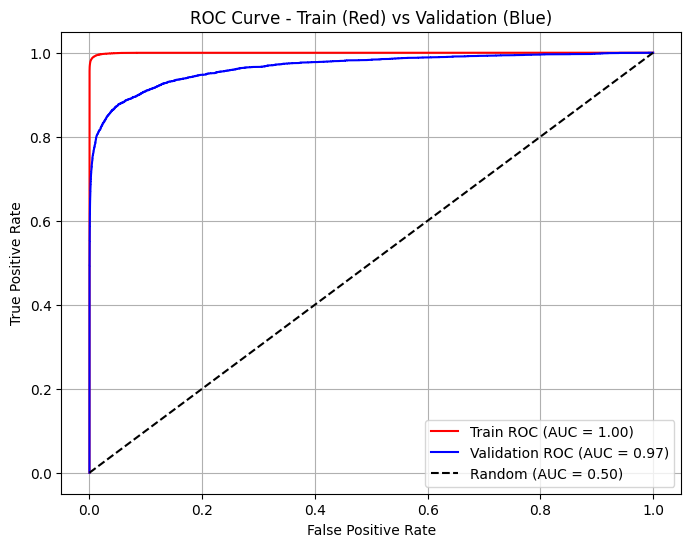

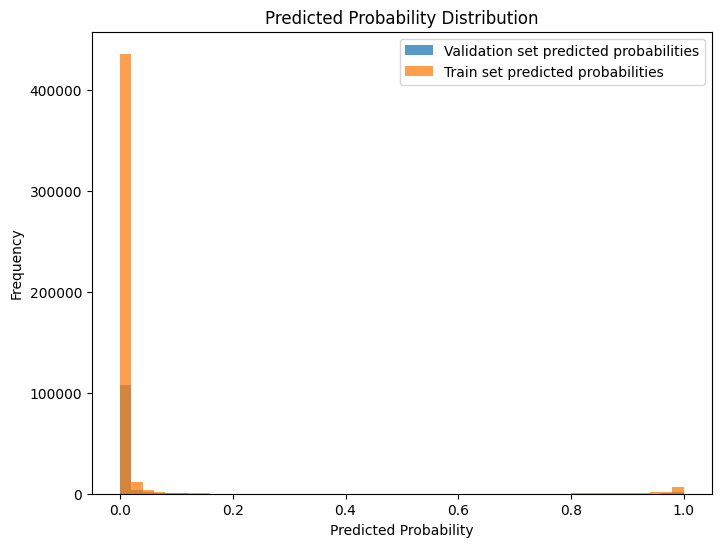

🏃 View run XGboost_Model at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/1/runs/c3b20d10d9984663b2a8663027be01bc
🧪 View experiment at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/1


In [34]:
with mlflow.start_run(run_name='XGboost_Model'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    columns_df = pd.DataFrame(columns_selected, columns=["selected_column"]) 
    columns_df.to_csv("selected_columns.csv", index=False)
    mlflow.log_artifact("selected_columns.csv")
    del columns_df

    mlflow.log_param("corelation_filter_threshold", 0.9)
    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess_and_selecting.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "200")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 0)
    mlflow.log_param("xgboost_reg_lambda", 50)